In [7]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
import pandas as pd

df = pd.read_csv('mta_manhattan_2024_merged_hourly.csv', low_memory=False)


# define 'mode function' to normalize latitude and longitude, according to the original data includes
# different entrance and exit, which is same station.
def get_mode(series):
    return series.mode().iloc[0]

mapping = df.groupby(['station_complex_id', 'station_complex']).agg({
    'latitude': get_mode,
    'longitude': get_mode
}).reset_index()

mapping.to_csv('station_mapping_mode.csv', index=False)

print(mapping)

    station_complex_id                     station_complex   latitude  \
0                   10                       49 St (N,R,W)  40.759900   
1                  103                        Bowery (J,Z)  40.720280   
2                  107                      Broad St (J,Z)  40.706474   
3                  118                            3 Av (L)  40.732850   
4                  119                            1 Av (L)  40.730953   
..                 ...                                 ...        ...   
118                635  South Ferry (1)/Whitehall St (R,W)  40.703087   
119                  8                  5 Av/59 St (N,R,W)  40.764812   
120                  9                57 St-7 Av (N,Q,R,W)  40.764664   
121              TRAM1              RI Tramway (Manhattan)  40.761337   
122              TRAM2              RI Tramway (Roosevelt)  40.757340   

     longitude  
0   -73.984140  
1   -73.993910  
2   -74.011055  
3   -73.986120  
4   -73.981630  
..         ...  
118 

In [6]:
df.tail(5)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,transfers,latitude,longitude,georeference,hour,ridership
345509,2024-12-31 16:00:00,subway,413,"Wall St (4,5)",Manhattan,metrocard,Metrocard - Unlimited 30-Day,0.0,40.707558,-74.01186,"{'type': 'Point', 'coordinates': [-74.01186, 4...",2024-12-31 16:00:00,996.0
345510,2024-12-31 17:00:00,subway,413,"Wall St (4,5)",Manhattan,omny,OMNY - Full Fare,4.0,40.707558,-74.01186,"{'type': 'Point', 'coordinates': [-74.01186, 4...",2024-12-31 17:00:00,785.0
345511,2024-12-31 18:00:00,subway,413,"Wall St (4,5)",Manhattan,omny,OMNY - Full Fare,1.0,40.707558,-74.01186,"{'type': 'Point', 'coordinates': [-74.01186, 4...",2024-12-31 18:00:00,475.0
345512,2024-12-31 19:00:00,subway,413,"Wall St (4,5)",Manhattan,omny,OMNY - Full Fare,2.0,40.707558,-74.01186,"{'type': 'Point', 'coordinates': [-74.01186, 4...",2024-12-31 19:00:00,419.0
345513,2024-12-31 20:00:00,subway,413,"Wall St (4,5)",Manhattan,metrocard,Metrocard - Unlimited 7-Day,0.0,40.707558,-74.01186,"{'type': 'Point', 'coordinates': [-74.01186, 4...",2024-12-31 20:00:00,303.0


In [12]:
df.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
transfers              float64
latitude               float64
longitude              float64
georeference            object
hour                    object
ridership              float64
dtype: object

In [13]:
#Look for constant columns. Consider whether it makes sense to keep them or drop them.
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(f"Constant columns: {constant_columns}")

df.drop(columns=constant_columns, inplace=True)

Constant columns: ['borough']


Note - transit_mode include "subway"/"Tram", we are not using tram here but just in case we don't delete it immediately.

In [ ]:
#delete useless columns and transfer dtypes
df = df.drop(columns=['payment_method', 'fare_class_category', 'transfers', 'georeference'])

df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df['ridership'] = df['ridership'].astype('Int64')
df['station_complex_id'] = df['station_complex_id'].astype('category')
df['station_complex'] = df['station_complex'].astype('category')
df['transit_mode'] = df['transit_mode'].astype('category')

print(df.dtypes)

transit_timestamp     datetime64[ns]
transit_mode                category
station_complex_id          category
station_complex             category
latitude                     float64
longitude                    float64
hour                           Int64
ridership                      Int64
dtype: object


In [19]:
df.dtypes

transit_timestamp     datetime64[ns]
transit_mode                category
station_complex_id          category
station_complex             category
latitude                     float64
longitude                    float64
ridership                      Int64
dtype: object

In [20]:
df2 = df.copy()

check missing values and missing rate

In [21]:
total = len(df2)

missing_counts = df2.isnull().sum()
missing_percent = (missing_counts / total) * 100

missing_report = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
})

print(missing_report)

                    missing_count  missing_percent
transit_timestamp               0              0.0
transit_mode                    0              0.0
station_complex_id              0              0.0
station_complex                 0              0.0
latitude                        0              0.0
longitude                       0              0.0
ridership                       0              0.0


In [22]:
# remove duplicate columns/columns with no analytical significance.
duplicate_rows = df2.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}" )

df2 = df2.drop_duplicates()

Duplicate rows: 0


### Descriptive Table (numeric)

In [23]:
from IPython.display import display
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns
interval_columns = df2.select_dtypes(include=['datetime64[ns]']).columns

print("1. Show continuous features:")
print("Numeric Columns:", numeric_columns)
print("Datetime Columns:", interval_columns)

print("2. Descriptive statistics table - continuous features")

numeric_sum = df2[numeric_columns].describe().T

interval_sum = df2[interval_columns].describe().T

table_continuous = pd.concat([numeric_sum, interval_sum])

# display(table_continuous)

con_columns = list(numeric_columns) + list(interval_columns)
df_table_continuous = df2[con_columns].describe(include="all").T

display(df_table_continuous)

1. Show continuous features:
Numeric Columns: Index(['latitude', 'longitude', 'ridership'], dtype='object')
Datetime Columns: Index(['transit_timestamp'], dtype='object')
2. Descriptive statistics table - continuous features


,count,mean,min,25%,50%,75%,max,std
latitude,345514.0,40.770221,40.70207,40.732338,40.762455,40.802097,40.87456,0.045287
longitude,345514.0,-73.973479,-74.01407,-73.99391,-73.97992,-73.95179,-73.90983,0.026224
ridership,345514.0,647.331908,1.0,72.0,284.0,722.0,24379.0,1145.044394
transit_timestamp,345514,2024-07-27 16:42:23.726737408,2024-02-01 08:00:00,2024-06-02 14:00:00,2024-09-02 13:00:00,2024-12-02 11:00:00,2024-12-31 20:00:00,NaN


<mark>Observation</mark>
1. ridership Max extremely high, can look into box plot

In [24]:
df2['hour'] = df2['transit_timestamp'].dt.hour
df2['weekday'] = df2['transit_timestamp'].dt.weekday
df2['is_weekend'] = (df2['weekday'] >= 5).astype(int)
df2['month'] = df2['transit_timestamp'].dt.month

In [25]:
df2.head(3)

,transit_timestamp,transit_mode,station_complex_id,station_complex,latitude,longitude,ridership,hour,weekday,is_weekend,month
0,2024-02-01 08:00:00,subway,119,1 Av (L),40.730953,-73.98163,2117,8,3,0,2
1,2024-02-01 09:00:00,subway,119,1 Av (L),40.730953,-73.98163,1394,9,3,0,2
2,2024-02-01 10:00:00,subway,119,1 Av (L),40.730953,-73.98163,769,10,3,0,2


### Descriptive Table (categorical)

In [26]:
print("1. Descriptive statistics table - categorical features")
cat_columns = df2.select_dtypes(include=["category", "object"]).columns
df_table_categ = df2[cat_columns].describe(include="all").T
display(df_table_categ)

1. Descriptive statistics table - categorical features


,count,unique,top,freq
transit_mode,345514,2,subway,340406
station_complex_id,345514,123,10,2836
station_complex,345514,123,103 St (6),2836


In [28]:
#missing data
# Prepare %missing column
category_columns_perc_missing  = 100 * (df2[cat_columns].isnull().sum()/df2.shape[0])
#category_columns_perc_missing

# Store the values in a dataframe
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
df_category_perc_missing

,%missing
transit_mode,0.0
station_complex_id,0.0
station_complex,0.0


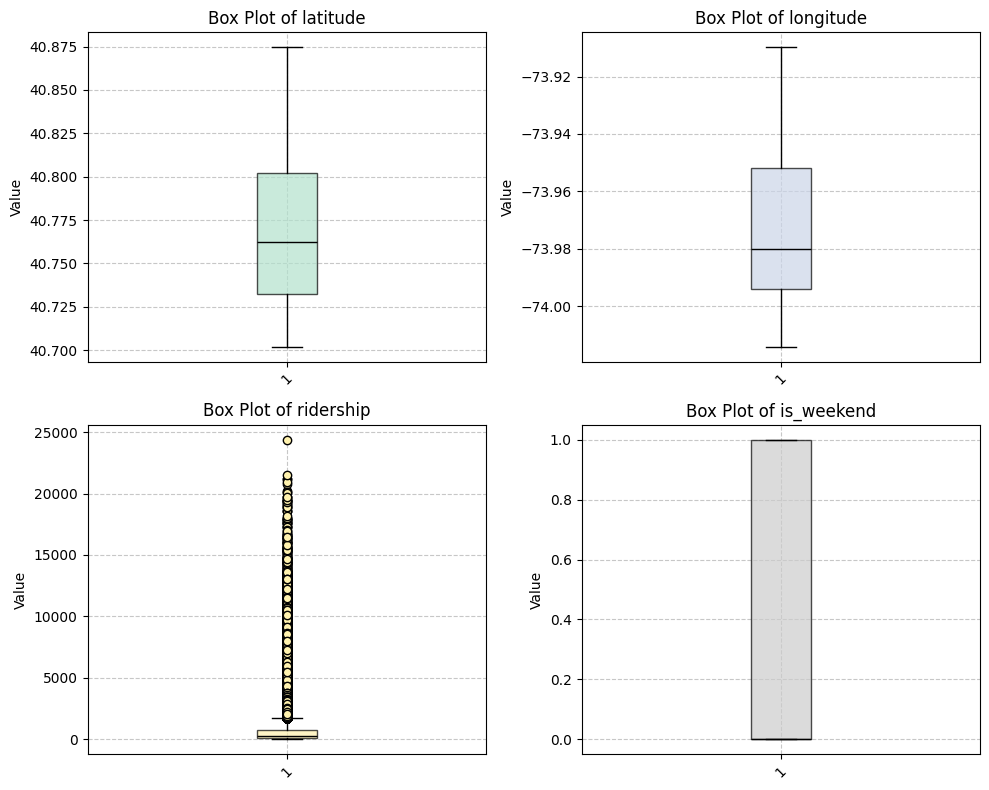

In [29]:
#continuous variable columns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

continuous_column = df2.select_dtypes(include=['int64', 'float64']).columns

n_features = len(continuous_column)
n_rows = (n_features + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))
axes = axes.ravel()

# Set color cycle
colors = plt.cm.Pastel2(np.linspace(0, 1, n_features))

with PdfPages('Continuous_boxplots.pdf') as pp:

    # Create box plots for each feature
    for idx, (column, color) in enumerate(zip(continuous_column, colors)):
        # Ensure data is numeric and drop null values
        data = df2[column].dropna().astype(float)
        

        box_plot = axes[idx].boxplot(data,
                                    patch_artist=True,
                                    medianprops={'color': 'black'},
                                    flierprops={'marker': 'o',
                                            'markerfacecolor': color,
                                            'markeredgecolor': 'black'},
                                    boxprops={'facecolor': color,
                                            'alpha': 0.7})
        
        axes[idx].set_title(f'Box Plot of {column}')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, linestyle='--', alpha=0.7)
        
        axes[idx].tick_params(axis='x', rotation=45)

    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])
        
fig.savefig("Continuous_boxplots.pdf")
plt.tight_layout()
plt.show()


In [31]:
df2.head(20)

,transit_timestamp,transit_mode,station_complex_id,station_complex,latitude,longitude,ridership,hour,weekday,is_weekend,month
0,2024-02-01 08:00:00,subway,119,1 Av (L),40.730953,-73.98163,2117,8,3,0,2
1,2024-02-01 09:00:00,subway,119,1 Av (L),40.730953,-73.98163,1394,9,3,0,2
2,2024-02-01 10:00:00,subway,119,1 Av (L),40.730953,-73.98163,769,10,3,0,2
3,2024-02-01 11:00:00,subway,119,1 Av (L),40.730953,-73.98163,642,11,3,0,2
4,2024-02-01 12:00:00,subway,119,1 Av (L),40.730953,-73.98163,675,12,3,0,2
5,2024-02-01 13:00:00,subway,119,1 Av (L),40.730953,-73.98163,662,13,3,0,2
6,2024-02-01 14:00:00,subway,119,1 Av (L),40.730953,-73.98163,1108,14,3,0,2
7,2024-02-01 15:00:00,subway,119,1 Av (L),40.730953,-73.98163,1304,15,3,0,2
8,2024-02-01 16:00:00,subway,119,1 Av (L),40.730953,-73.98163,1346,16,3,0,2
9,2024-02-01 17:00:00,subway,119,1 Av (L),40.730953,-73.98163,1470,17,3,0,2


In [32]:
df2.shape

(345514, 11)

In [33]:
# Save the cleaned dataframe
cleaned_file_path = 'cleaned_data_mta.csv'
df2.to_csv(cleaned_file_path, index=False)
print(f" Saved cleaned data to {cleaned_file_path}")

 Saved cleaned data to cleaned_data_mta.csv
